In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from keras.utils import to_categorical
init_notebook_mode(connected=True)

In [2]:
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10
TEST_SIZE = 0.2
RANDOM_STATE = 2018
#Model
NO_EPOCHS = 20
BATCH_SIZE = 128

IS_LOCAL = False

import os



# Load the Dataset

#### Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes

In [3]:
def Load_data():
    train_file = "fashion-mnist_train.csv"
    test_file  = "fashion-mnist_test.csv"

    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    return train_data,test_data

In [4]:
train_data,test_data = Load_data()

In [5]:
def DF_info(x,y):
    print("Fashion MNIST train -  rows:",x.shape[0]," columns:", x.shape[1])
    print("Fashion MNIST test -  rows:",y.shape[0]," columns:", y.shape[1])

In [6]:
DF_info(train_data,test_data)

Fashion MNIST train -  rows: 60000  columns: 785
Fashion MNIST test -  rows: 10000  columns: 785


# Labeling and counting each item and ploting item distribution

In [7]:

# Create a dictionary for each type of label 
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def get_classes_distribution(data):
    # Get the count for each label
    label_counts = data["label"].value_counts()

    # Get total number of samples
    total_samples = len(data)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

get_classes_distribution(train_data)



Ankle Boot          :   6000 or 10.0%
Bag                 :   6000 or 10.0%
Sneaker             :   6000 or 10.0%
Shirt               :   6000 or 10.0%
Sandal              :   6000 or 10.0%
Coat                :   6000 or 10.0%
Dress               :   6000 or 10.0%
Pullover            :   6000 or 10.0%
Trouser             :   6000 or 10.0%
T-shirt/top         :   6000 or 10.0%


C:\Users\priya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



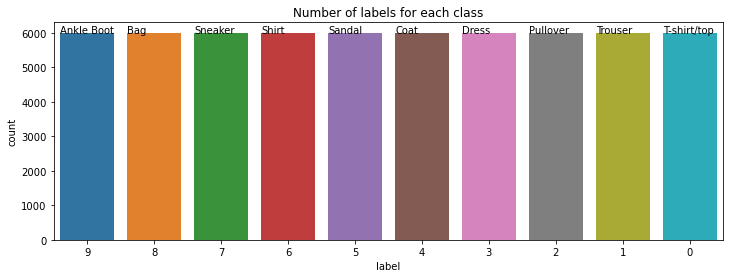

In [8]:
# plotting the items by their coubnt in the class
def plot_label_per_class(data):
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(data.label, order = data["label"].value_counts().index)
    g.set_title("Number of labels for each class")

    for p, label in zip(g.patches, data["label"].value_counts().index):
        g.annotate(labels[label], (p.get_x(), p.get_height()+0.1))
    plt.show()  
    
plot_label_per_class(train_data)

In [9]:
get_classes_distribution(test_data)

Sneaker             :   1000 or 10.0%
Shirt               :   1000 or 10.0%
Sandal              :   1000 or 10.0%
Coat                :   1000 or 10.0%
Dress               :   1000 or 10.0%
Pullover            :   1000 or 10.0%
Ankle Boot          :   1000 or 10.0%
Trouser             :   1000 or 10.0%
Bag                 :   1000 or 10.0%
T-shirt/top         :   1000 or 10.0%


C:\Users\priya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



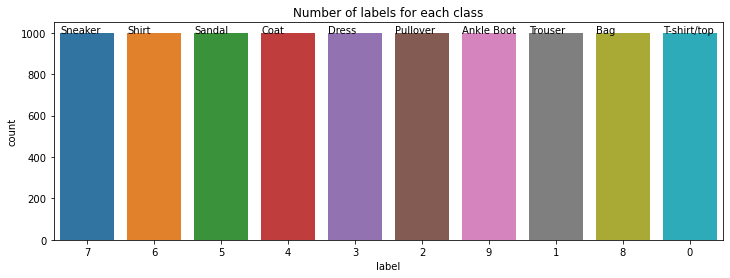

In [10]:
plot_label_per_class(test_data)

In [11]:
def sample_images_data(data):
    # An empty list to collect some samples
    sample_images = []
    sample_labels = []

    # Iterate over the keys of the labels dictionary defined in the above cell
    for k in labels.keys():
        # Get four samples for each category
        samples = data[data["label"] == k].head(4)
        # Append the samples to the samples list
        for j, s in enumerate(samples.values):
            # First column contain labels, hence index should start from 1
            img = np.array(samples.iloc[j, 1:]).reshape(IMG_ROWS,IMG_COLS)
            sample_images.append(img)
            sample_labels.append(samples.iloc[j, 0])

    print("Total number of sample images to plot: ", len(sample_images))
    return sample_images, sample_labels

In [12]:
train_sample_images, train_sample_labels = sample_images_data(train_data)

Total number of sample images to plot:  40


## Plot sample item images

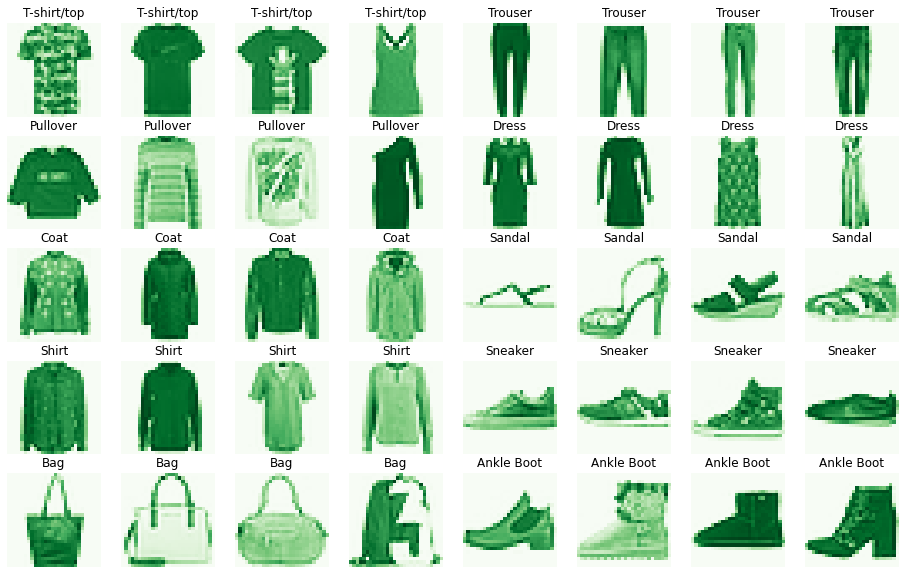

In [13]:
def plot_sample_images(data_sample_images,data_sample_labels,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(5,8, figsize=(16,10))

    for i, img in enumerate(data_sample_images):
        ax[i//8, i%8].imshow(img, cmap=cmap)
        ax[i//8, i%8].axis('off')
        ax[i//8, i%8].set_title(labels[data_sample_labels[i]])
    plt.show()    
    
plot_sample_images(train_sample_images,train_sample_labels, "Greens")

Total number of sample images to plot:  40


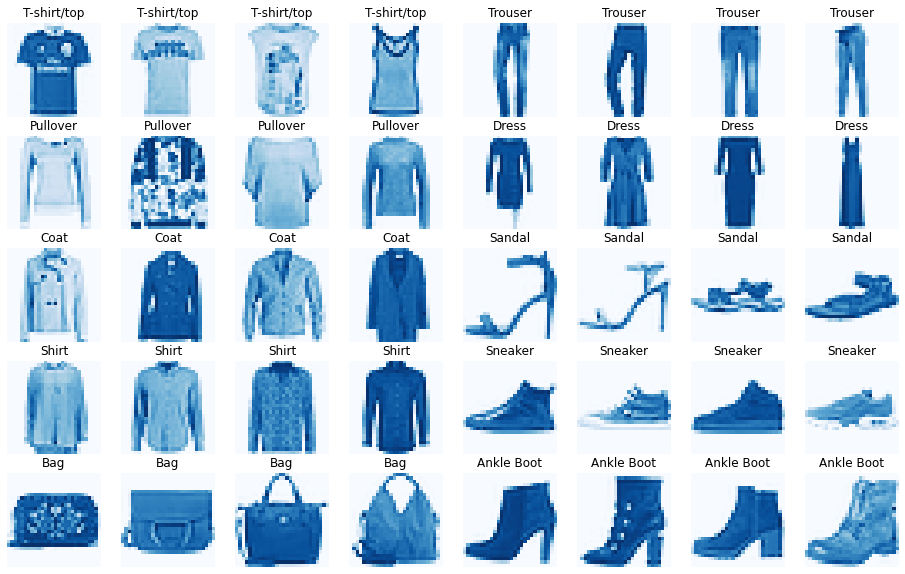

In [14]:
test_sample_images, test_sample_labels = sample_images_data(test_data)
plot_sample_images(test_sample_images,test_sample_labels)

# Data Preprocessing

In [15]:
# data preprocessing
def data_preprocessing(raw):
    out_y = to_categorical(raw.label, NUM_CLASSES)
    num_images = raw.shape[0]
    x_as_array = raw.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, IMG_ROWS, IMG_COLS, 1)
    out_x = x_shaped_array / 255
    return out_x, out_y

In [16]:
# prepare the data
X, y = data_preprocessing(train_data)
X_test, y_test = data_preprocessing(test_data)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [18]:
print("Fashion MNIST train -  rows:",X_train.shape[0]," columns:", X_train.shape[1:4])
print("Fashion MNIST valid -  rows:",X_val.shape[0]," columns:", X_val.shape[1:4])
print("Fashion MNIST test -  rows:",X_test.shape[0]," columns:", X_test.shape[1:4])

Fashion MNIST train -  rows: 48000  columns: (28, 28, 1)
Fashion MNIST valid -  rows: 12000  columns: (28, 28, 1)
Fashion MNIST test -  rows: 10000  columns: (28, 28, 1)


C:\Users\priya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



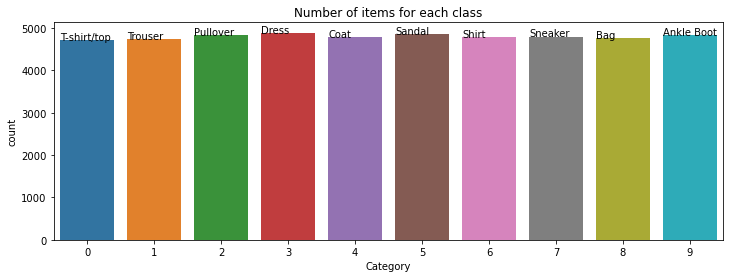

Dress               :   4891 or 10.189583333333333%
Sandal              :   4855 or 10.114583333333334%
Pullover            :   4836 or 10.075000000000001%
Ankle Boot          :   4827 or 10.05625%
Sneaker             :   4798 or 9.995833333333334%
Coat                :   4796 or 9.991666666666667%
Shirt               :   4779 or 9.95625%
Bag                 :   4757 or 9.910416666666666%
Trouser             :   4745 or 9.885416666666668%
T-shirt/top         :   4716 or 9.825000000000001%


In [19]:
def plot_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(ydf[0], order = np.arange(0,10))
    g.set_title("Number of items for each class")
    g.set_xlabel("Category")
    
    for p, label in zip(g.patches, np.arange(0,10)):
        g.annotate(labels[label], (p.get_x(), p.get_height()+0.1))
        
    plt.show()  

def get_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    # Get the count for each label
    label_counts = ydf[0].value_counts()

    # Get total number of samples
    total_samples = len(yd)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))
    
plot_count_per_class(np.argmax(y_train,axis=1))
get_count_per_class(np.argmax(y_train,axis=1))

C:\Users\priya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



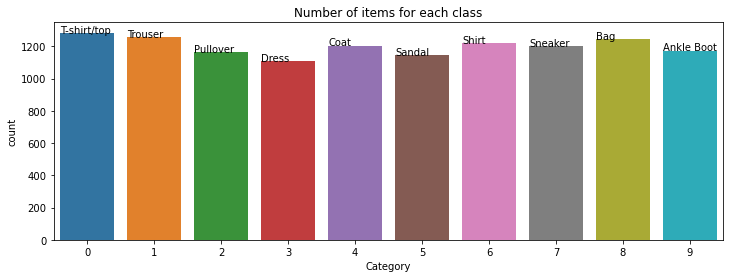

T-shirt/top         :   1284 or 10.7%
Trouser             :   1255 or 10.458333333333334%
Bag                 :   1243 or 10.358333333333333%
Shirt               :   1221 or 10.174999999999999%
Coat                :   1204 or 10.033333333333333%
Sneaker             :   1202 or 10.016666666666667%
Ankle Boot          :   1173 or 9.775%
Pullover            :   1164 or 9.700000000000001%
Sandal              :   1145 or 9.541666666666666%
Dress               :   1109 or 9.241666666666665%


In [20]:
plot_count_per_class(np.argmax(y_val,axis=1))
get_count_per_class(np.argmax(y_val,axis=1))

## CNN (convolutional neural network)

#### In deep learning, a convolutional neural network (CNN) is a class of deep neural network, most commonly applied to analyze visual imagery. They are also known as shift invariant or space invariant artificial neural networks (SIANN), based on the shared-weight architecture of the convolution kernels or filters that slide along input features and provide translation equivariant responses known as feature maps

# Model Training

In [21]:
model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),
            activation='relu',
            kernel_initializer='he_normal',
            input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, 
            kernel_size=(3, 3), 
            activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [23]:
def train_model(model):
    return model.fit(X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=NO_EPOCHS,
    verbose=1,
    validation_data=(X_val, y_val))
train_model(model)

Epoch 1/20
375/375 [==============================] - 22s 59ms/step - loss: 0.7622 - accuracy: 0.7210 - val_loss: 0.4284 - val_accuracy: 0.8506
Epoch 2/20
375/375 [==============================] - 21s 56ms/step - loss: 0.3617 - accuracy: 0.8676 - val_loss: 0.3191 - val_accuracy: 0.8880
Epoch 3/20
375/375 [==============================] - 22s 58ms/step - loss: 0.3019 - accuracy: 0.8906 - val_loss: 0.2923 - val_accuracy: 0.8972
Epoch 4/20
375/375 [==============================] - 22s 58ms/step - loss: 0.2644 - accuracy: 0.9046 - val_loss: 0.2871 - val_accuracy: 0.8935
Epoch 5/20
375/375 [==============================] - 22s 57ms/step - loss: 0.2353 - accuracy: 0.9146 - val_loss: 0.2764 - val_accuracy: 0.9010
Epoch 6/20
375/375 [==============================] - 22s 60ms/step - loss: 0.2046 - accuracy: 0.9228 - val_loss: 0.2728 - val_accuracy: 0.9046
Epoch 7/20
375/375 [==============================] - 23s 60ms/step - loss: 0.1937 - accuracy: 0.9289 - val_loss: 0.2610 - val_accuracy:

In [24]:
def print_score(model):
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
print_score(model)

Test loss: 0.41795092821121216
Test accuracy: 0.9115999937057495


In [25]:
# Model
model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(MaxPooling2D((2, 2)))
# Add dropouts to the model
model.add(Dropout(0.25))
model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [26]:
def train_model(model):
    model.fit(X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=NO_EPOCHS,
    verbose=1,
    validation_data=(X_val, y_val))
train_model(model)

Epoch 1/20
375/375 [==============================] - 28s 73ms/step - loss: 1.0405 - accuracy: 0.6172 - val_loss: 0.4678 - val_accuracy: 0.8353
Epoch 2/20
375/375 [==============================] - 28s 75ms/step - loss: 0.4914 - accuracy: 0.8191 - val_loss: 0.3783 - val_accuracy: 0.8602
Epoch 3/20
375/375 [==============================] - 28s 75ms/step - loss: 0.4110 - accuracy: 0.8443 - val_loss: 0.3251 - val_accuracy: 0.8842
Epoch 4/20
375/375 [==============================] - 28s 76ms/step - loss: 0.3689 - accuracy: 0.8652 - val_loss: 0.3014 - val_accuracy: 0.8899
Epoch 5/20
375/375 [==============================] - 27s 73ms/step - loss: 0.3374 - accuracy: 0.8765 - val_loss: 0.2906 - val_accuracy: 0.8954
Epoch 6/20
375/375 [==============================] - 27s 73ms/step - loss: 0.3238 - accuracy: 0.8806 - val_loss: 0.2776 - val_accuracy: 0.9009
Epoch 7/20
375/375 [==============================] - 27s 73ms/step - loss: 0.3096 - accuracy: 0.8859 - val_loss: 0.2641 - val_accuracy:

In [27]:
#plot_accuracy_and_loss(train_model)

In [28]:
def print_score(model):
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
print_score(model)

Test loss: 0.218499094247818
Test accuracy: 0.9185000061988831


In [29]:
#get the predictions for the test data
def assignm(model,test_data):
    predicted_classes = model.predict_classes(X_test)
    #get the indices to be plotted
    y_true = test_data.iloc[:, 0]
    return predicted_classes, y_true

In [30]:
p,y = assignm(model,test_data)
y = np.array(y)
print(p.shape)
print(y.shape)
# print(p[:10])
print(y[:20])
correct = incorrect = 0
for p1,y1 in zip(p,y):
    if p1 == y1:
        correct +=1 
    else:
        incorrect += 1

correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

C:\Users\priya\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



(10000,)
(10000,)
[0 1 2 2 3 2 8 6 5 0 3 4 4 6 8 5 6 3 6 4]


In [31]:
print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 9185
Incorrect predicted classes: 815


In [32]:
target_names = ["Class {} ({}) :".format(i,labels[i]) for i in range(NUM_CLASSES)]
print(classification_report(y, p, target_names=target_names))

                         precision    recall  f1-score   support

Class 0 (T-shirt/top) :       0.87      0.86      0.87      1000
    Class 1 (Trouser) :       0.99      0.98      0.99      1000
   Class 2 (Pullover) :       0.90      0.86      0.88      1000
      Class 3 (Dress) :       0.92      0.94      0.93      1000
       Class 4 (Coat) :       0.91      0.84      0.87      1000
     Class 5 (Sandal) :       0.99      0.97      0.98      1000
      Class 6 (Shirt) :       0.72      0.80      0.76      1000
    Class 7 (Sneaker) :       0.95      0.97      0.96      1000
        Class 8 (Bag) :       0.99      0.98      0.99      1000
 Class 9 (Ankle Boot) :       0.97      0.97      0.97      1000

               accuracy                           0.92     10000
              macro avg       0.92      0.92      0.92     10000
           weighted avg       0.92      0.92      0.92     10000



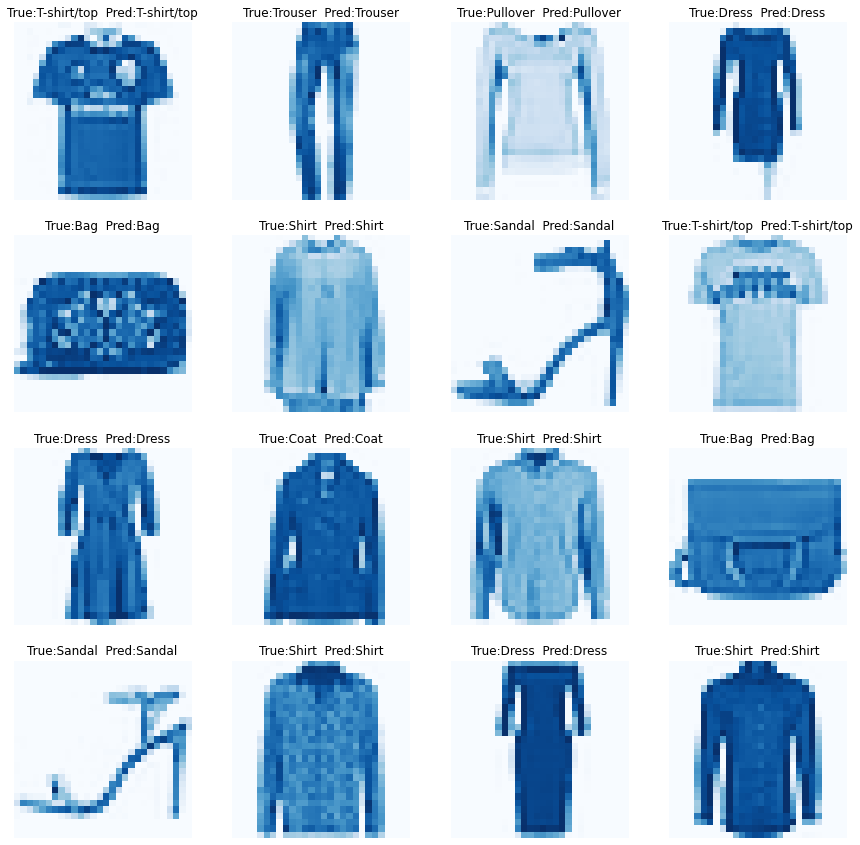

In [33]:
def plot_images(data_index,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(4,4, figsize=(15,15))

    for i, indx in enumerate(data_index[:16]):
        ax[i//4, i%4].imshow(X_test[indx].reshape(IMG_ROWS,IMG_COLS), cmap=cmap)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title("True:{}  Pred:{}".format(labels[y[indx]],labels[p[indx]]))
    plt.show()    
    
plot_images(correct)

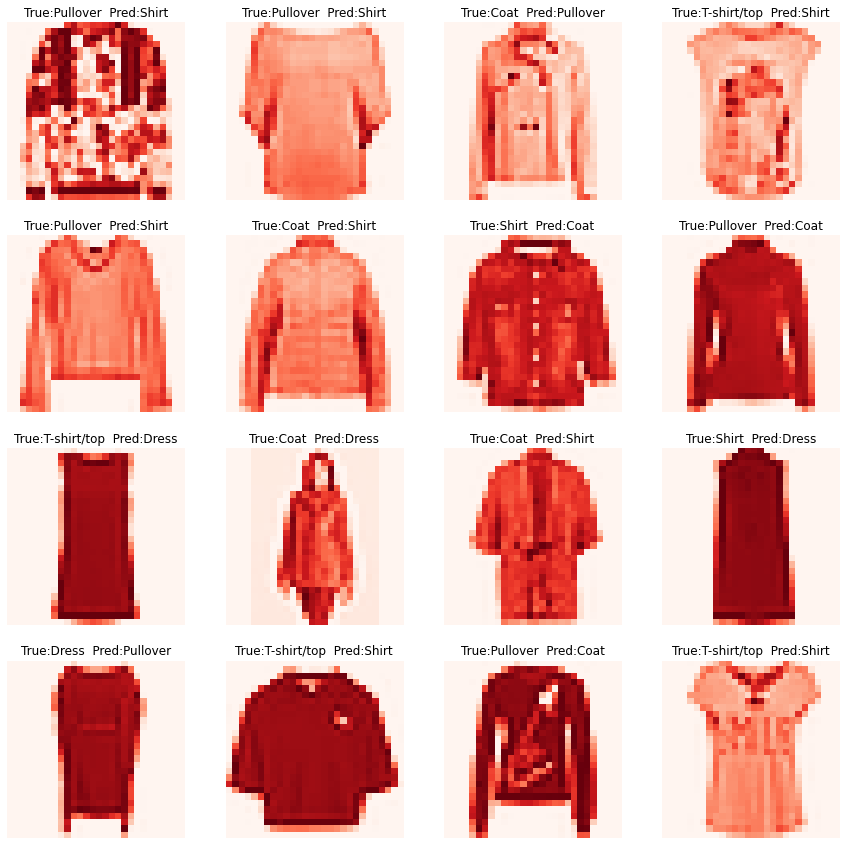

In [34]:
plot_images(incorrect, "Reds")